In [1]:
import os
import cv2
# import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

In [2]:
# require packags
import pandas as pd
import numpy as np
import glob
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import tensorflow as tf
import keras
import glob
from keras.layers import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input,Flatten, Conv2D, Concatenate, Dense, LSTM, Reshape, Dropout, TimeDistributed, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import glob
import tqdm
from PIL import Image

In [4]:
# confugure hyper parameters
num_classes = 2
input_shape = (80,80,3)

patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 64  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 8
num_epochs = 40
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

In [5]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output


In [6]:

class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

In [7]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super(SwinTransformer, self).__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

In [8]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super(PatchMerging, self).__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, Concatenate
from keras.layers import Input, Conv2D, Concatenate


def FireModule(input_tensor, squeeze_channels, expand1x1_channels, expand3x3_channels):
    # Squeeze layer (1x1 convolution)
    squeeze = Conv2D(squeeze_channels, (1, 1), activation='relu', padding='same')(input_tensor)   
    # Expand layer (1x1 convolution)
    expand1x1 = Conv2D(expand1x1_channels, (1, 1), activation='relu', padding='same')(squeeze)
    # Expand layer (3x3 convolution)
    expand3x3 = Conv2D(expand3x3_channels, (3, 3), activation='relu', padding='same')(squeeze)
    # Create a list of the two expand layers' outputs
    expand_outputs = [expand1x1, expand3x3]
    # Concatenate the list of outputs along the channel dimension
    concat = Concatenate(axis=-1)(expand_outputs)
    return concat

squeeze_channels = 16
expand1x1_channels = 80
expand3x3_channels = 80

In [10]:
seed_constant = 25
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [11]:
# IMAGE_HEIGHT , IMAGE_WIDTH = 64 , 64

# # Specify the number of frames of a video that will be fed to the model as one sequence.
# SEQUENCE_LENGTH = 20
# DATASET_DIR = 'PROPOSED_DATASET'  # Change this to the directory where you extracted the data
# CLASSES_LIST = ['fight', 'nonfight']

In [12]:
# def frames_extraction(video_path):
 

#     # Declare a list to store video frames.
#     frames_list = []

#     video_reader = cv2.VideoCapture(video_path)    
#     video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

#     # Calculate the the interval after which frames will be added to the list.
#     skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    
#     for frame_counter in range(SEQUENCE_LENGTH):

#         # Set the current frame position of the video.
#         video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

#         # Reading the frame from the video.
#         success, frame = video_reader.read()

#         # Check if Video frame is not successfully read then break the loop
#         if not success:
#             break

#         # Resize the Frame to fixed height and width.
#         resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

#         # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
#         normalized_frame = resized_frame / 255

#         # Append the normalized frame into the frames list
#         frames_list.append(normalized_frame)

#     # Release the VideoCapture object.
#     video_reader.release()
    

#     # Return the frames list.
#     return frames_list

In [13]:
# def create_dataset():
#     '''
#     This function will extract the data of the selected classes and create the required dataset.
#     Returns:
#         features:          A list containing the extracted frames of the videos.
#         labels:            A list containing the indexes of the classes associated with the videos.
#         video_files_paths: A list containing the paths of the videos in the disk.
#     '''

#     # Declared Empty Lists to store the features, labels and video file path values.
#     features = []
#     labels = []
#     video_files_paths = []

#     # Iterating through all the classes mentioned in the classes list
#     for class_index, class_name in enumerate(CLASSES_LIST):

#         # Display the name of the class whose data is being extracted.
#         print(f'Extracting Data of Class: {class_name}')

#         # Get the list of video files present in the specific class name directory.
#         files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

#         # Iterate through all the files present in the files list.
#         for file_name in files_list:

#             # Get the complete video path.
#             video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

#             # Extract the frames of the video file.
#             frames = frames_extraction(video_file_path)
#             print(len(frames))

#             # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
#             # So ignore the vides having frames less than the SEQUENCE_LENGTH.
#             if len(frames) == SEQUENCE_LENGTH:

#                 # Append the data to their repective lists.
#                 features.append(frames)
#                 labels.append(class_index)
#                 video_files_paths.append(video_file_path)

#     # Converting the list to numpy arrays
#     features = np.asarray(features)
#     labels = np.array(labels)

#     # Return the frames, class index, and video file path.
#     return features, labels, video_files_paths
#     print(labels)
#     features

In [14]:

# # Create the dataset.
# features, labels, video_files_paths = create_dataset()

In [15]:
features=np.load("features.npy")
labels=np.load("labels.npy")

In [16]:
labels = np.expand_dims(labels, axis = 1)

In [17]:
features.shape

(1874, 18, 80, 80, 3)

In [18]:
labels.shape

(1874, 1)

In [17]:

# ones = np.ones((360,1), dtype = int)
# zero = np.zeros((359,1), dtype = int)

In [18]:
# labels=labels.reshape((719, 1))

In [19]:
# labels = np.concatenate((zero,ones))


In [19]:
labels.shape

(1874, 1)

In [19]:

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.20, shuffle = True, random_state = seed_constant)

In [20]:
features_train.shape , features_test.shape , labels_train.shape , labels_test.shape

((1499, 18, 80, 80, 3), (375, 18, 80, 80, 3), (1499, 1), (375, 1))

In [21]:
(labels_train==1).sum(),(labels_train==0).sum(),(labels_test==1).sum(),(labels_test==0).sum()

(791, 708, 201, 174)

In [22]:
# Define the input layer
from tensorflow.keras.regularizers import l2
sequence_input = Input(shape=(18, 80, 80, 3))

# Apply TimeDistributed Conv2D
x = TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'))(sequence_input)
x = TimeDistributed(BatchNormalization())(x)

x = TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'))(x)
x = TimeDistributed(BatchNormalization())(x)

x = TimeDistributed(Conv2D(3, (3, 3), padding='same', activation='relu'))(x)

x = Flatten()(x)
x = Reshape((80,80, -1))(x)

# fire module
x = FireModule(x,squeeze_channels, expand1x1_channels, expand3x3_channels)

# swin transformer
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)




x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)

l2_lambda = 0.01  # Adjust the regularization strength as needed
x = layers.Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda))(x)



output = layers.Dense(1, activation="sigmoid")(x)

In [23]:
# from tensorflow.keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(
#     monitor='val_loss',  # You can use 'val_loss' or 'val_accuracy' as the monitored metric
#     patience=10,         
#     restore_best_weights=True  
# )


In [28]:
# model creatoin
model = keras.Model(sequence_input, output)

learning_rate=0.001
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 18, 80, 80, 3)]      0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 18, 80, 80, 16)       448       ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (None, 18, 80, 80, 16)       64        ['time_distributed[0][0]']    
 stributed)                                                                                       
                                                                                            

In [29]:
history = model.fit(features_train,labels_train, 
                    epochs=100,
                    validation_data=(features_test, labels_test), 
                    batch_size=1,
#                     callbacks=[early_stopping]
                   )


Epoch 1/100
1499/1499 [==============================] - 5019s 3s/step - loss: 0.1108 - accuracy: 0.9686 - precision_2: 0.9650 - recall_2: 0.9760 - auc_2: 0.9897 - val_loss: 0.4939 - val_accuracy: 0.8853 - val_precision_2: 0.8435 - val_recall_2: 0.9652 - val_auc_2: 0.9668
Epoch 2/100
1499/1499 [==============================] - 270s 180ms/step - loss: 0.0702 - accuracy: 0.9807 - precision_2: 0.9762 - recall_2: 0.9874 - auc_2: 0.9959 - val_loss: 0.9248 - val_accuracy: 0.8880 - val_precision_2: 1.0000 - val_recall_2: 0.7910 - val_auc_2: 0.9484
Epoch 3/100
1499/1499 [==============================] - 270s 180ms/step - loss: 0.0737 - accuracy: 0.9820 - precision_2: 0.9751 - recall_2: 0.9912 - auc_2: 0.9956 - val_loss: 0.2144 - val_accuracy: 0.9333 - val_precision_2: 0.9536 - val_recall_2: 0.9204 - val_auc_2: 0.9814
Epoch 4/100
1499/1499 [==============================] - 268s 179ms/step - loss: 0.0387 - accuracy: 0.9913 - precision_2: 0.9887 - recall_2: 0.9949 - auc_2: 0.9984 - val_loss: 0

Epoch 31/100
1499/1499 [==============================] - 268s 179ms/step - loss: 0.0418 - accuracy: 0.9920 - precision_2: 0.9937 - recall_2: 0.9912 - auc_2: 0.9983 - val_loss: 0.1119 - val_accuracy: 0.9813 - val_precision_2: 0.9949 - val_recall_2: 0.9701 - val_auc_2: 0.9915
Epoch 32/100
1499/1499 [==============================] - 268s 179ms/step - loss: 0.0150 - accuracy: 0.9960 - precision_2: 0.9950 - recall_2: 0.9975 - auc_2: 1.0000 - val_loss: 0.3375 - val_accuracy: 0.9733 - val_precision_2: 0.9948 - val_recall_2: 0.9552 - val_auc_2: 0.9864
Epoch 33/100
1499/1499 [==============================] - 267s 178ms/step - loss: 0.1938 - accuracy: 0.9860 - precision_2: 0.9898 - recall_2: 0.9836 - auc_2: 0.9933 - val_loss: 0.1340 - val_accuracy: 0.9627 - val_precision_2: 0.9390 - val_recall_2: 0.9950 - val_auc_2: 0.9927
Epoch 34/100
1499/1499 [==============================] - 267s 178ms/step - loss: 0.1015 - accuracy: 0.9833 - precision_2: 0.9848 - recall_2: 0.9836 - auc_2: 0.9940 - val_l

Epoch 61/100
1499/1499 [==============================] - 268s 179ms/step - loss: 0.0487 - accuracy: 0.9887 - precision_2: 0.9850 - recall_2: 0.9937 - auc_2: 0.9982 - val_loss: 0.1858 - val_accuracy: 0.9760 - val_precision_2: 0.9848 - val_recall_2: 0.9701 - val_auc_2: 0.9864
Epoch 62/100
1499/1499 [==============================] - 268s 179ms/step - loss: 0.0331 - accuracy: 0.9927 - precision_2: 0.9875 - recall_2: 0.9987 - auc_2: 0.9994 - val_loss: 1.2725 - val_accuracy: 0.8827 - val_precision_2: 1.0000 - val_recall_2: 0.7811 - val_auc_2: 0.9417
Epoch 63/100
1499/1499 [==============================] - 268s 179ms/step - loss: 0.0124 - accuracy: 0.9973 - precision_2: 0.9987 - recall_2: 0.9962 - auc_2: 1.0000 - val_loss: 0.3464 - val_accuracy: 0.9547 - val_precision_2: 0.9946 - val_recall_2: 0.9204 - val_auc_2: 0.9817
Epoch 64/100
1499/1499 [==============================] - 268s 179ms/step - loss: 0.0226 - accuracy: 0.9973 - precision_2: 0.9975 - recall_2: 0.9975 - auc_2: 0.9987 - val_l

In [26]:
# Evaluate the model
evaluation_result = model.evaluate(features_test, labels_test)
print(f"Test Loss: {evaluation_result[0]}, Test Accuracy: {evaluation_result[1]}")



# Print the evaluation results
for metric_name, metric_value in zip(model.metrics_names, evaluation_result):
    print(f"{metric_name}: {metric_value}")


12/12 [==============================] - 12s 935ms/step - loss: 0.2267 - accuracy: 0.9387 - precision: 0.9588 - recall: 0.9254 - auc: 0.9776
Test Loss: 0.22671671211719513, Test Accuracy: 0.9386666417121887
loss: 0.22671671211719513
accuracy: 0.9386666417121887
precision: 0.9587628841400146
recall: 0.9253731369972229
auc: 0.9776118993759155


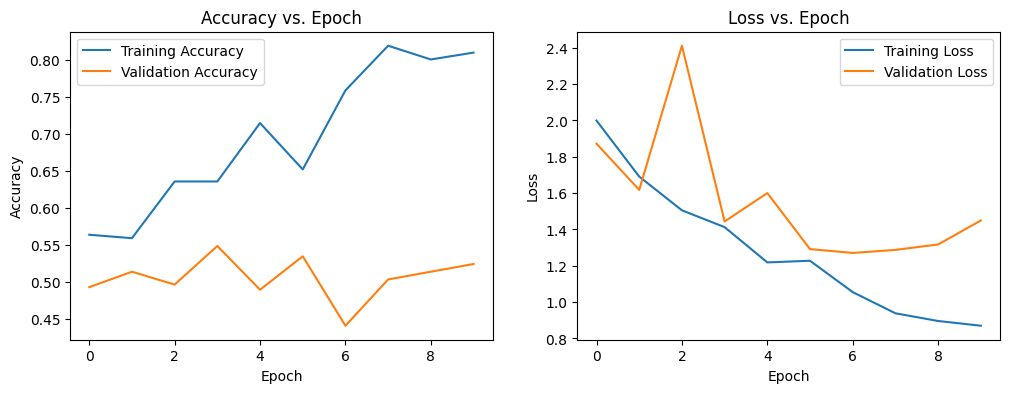

In [29]:
import matplotlib.pyplot as plt

# Access training history for accuracy and loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epoch')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epoch')

plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Assuming you have predictions from your model
predictions = model.predict(features_test)
predicted_classes = np.argmax(predictions, axis=1)
# print(predicted_classes)
# print("model_pred" , predictions)


# Assuming your true labels are in one-hot encoded format
true_classes = np.argmax(labels_test, axis=1)

# Calculate the confusion matrix
confusion = confusion_matrix(true_classes, predicted_classes)

confusion 